# Converge Spin Baths

In [5]:
# %load_ext autoreload
# %autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('NVcenter-default')

import numpy as np 
import matplotlib.pyplot as plt
import qutip as q
import time
import random
import seaborn as sns

### 1. Create spins baths (12 x 6 = 72)

In [188]:
for density_key in ['low_density', 'intermediate_density', 'high_density', 'very_high_density]:
    for depth in [5e-9, 10e-9, 15e-9]:

        density_dict = {'low_density': 1e-3/1e-18, 'intermediate_density': 5e-3/1e-18, 'high_density': 20e-3/1e-18, 'very_high_density': 50e-3/1e-18}
        density = density_dict[density_key]
        rmax = np.sqrt(7 / (density * np.pi))
        
        num_baths, num_init_states, all_init_states = 5000, 1, False
        directory = os.path.join(os.getcwd(), "baths", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
        filename = f"7_spins"
        kwargs = dict(
            density = density,
            shape = 'circle',
            rmin = 0, 
            rmax = rmax,
            depth = depth,
            bath_kwargs = dict(Bz=500e-4, depth=depth),
        )
        
        spin_bath = SpinBath('e', **kwargs)
        bath_configs, metadata = spin_bath.calc_spin_baths(num_baths, num_init_states, all_init_states=all_init_states)
        save_spin_baths(bath_configs, metadata, directory, filename)
        print("Saved as", os.path.join(directory, filename + '.json'))
        
        # bath_polarization = calc_bath_polarization(bath_configs)
        # print("Number of bath spins: ", spin_bath.num_spins)
        # print("Bath Polarization: ", bath_polarization)
        
        # directory = os.path.join(os.getcwd(), "baths", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
        # filename = os.path.join( "7_spins")
        # bath_configs, metadata = load_spin_baths(filename, directory, load_metadata=True)
        
        for num_spins in [2,3,4,5,6]:
            rmin, rmax_cutoff = 0, np.sqrt(num_spins / (density * np.pi))
            metadata['rmax'] = rmax_cutoff
            cutoff = np.sqrt( (depth)**2 + (rmax_cutoff)**2)
            bath_configs_filtered = cut_spin_bath(bath_configs, cutoff)
            
            filename_cutoff = os.path.join( f"{num_spins}_spins")
            save_spin_baths(bath_configs_filtered, metadata, directory, filename_cutoff)
            print("Saved as", os.path.join(directory, filename_cutoff + '.json'))

Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_5nm_depth\7_spins.json
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_5nm_depth\2_spins.json
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_5nm_depth\3_spins.json
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_5nm_depth\4_spins.json
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_5nm_depth\5_spins.json
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_5nm_depth\6_spins.json
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\baths\.important\converge\high_density_10nm_depth\7_spins.json
Saved as C:\Users\Dennis H

### 2. Calculate density matrix trajectories (50 batches per bath) 

In [2]:
t0 = time.time()

env_approx_level = 'full_bath'
Bz = 0

for density_key in ['high_density']: # ['low_density', 'intermediate_density', 'high_density', 'very_high_density]:
    for depth in [5e-9, 10e-9, 15e-9]:

        directory = os.path.join(os.getcwd(), "baths", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
        for batch_idx in np.arange(1, 51):
            for num_spins in [2,3,4,5,6,7]:
                filename = f'{num_spins}_spins'
                bath_configs = load_spin_baths(filename, directory)
                
                # create an instance of the Environment2 class
                register_config = [('NV', (0, 0, 0), 0, dict(D_gs=0, Bz=Bz, N_zz=0, can_flip=False))]
                bath_configs_batch = bath_configs[(batch_idx-1)*100:batch_idx*100]
                kwargs = dict(dm_offset=1e-5, verbose=False, env_approx_level=env_approx_level, bath_configs=bath_configs_batch, suter_method=False, thermal_bath=True, parallelization=True)
                env = Environment2(register_config, **kwargs)
            
                # calculate the populations
                t_end, t_steps = 100e-6, 500
                env.gate_props_list = [("free_evo", dict(t=t_end))]
                t_list = np.linspace(0, t_end, t_steps)
                HGate = 1j * env.calc_U_rot(np.pi, 0, theta=np.pi / 4)
                HGate_phase = 1j * env.calc_U_rot(np.pi, 0, theta=np.pi / 4) # np.pi/2
                old_register_states = [HGate * q.fock_dm(2,0) * HGate]
                states = env.calc_states(t_list=t_list, old_register_states=old_register_states)[0]
                states = np.array([(HGate_phase * state * HGate_phase).full() for state in states])
                
                # saving
                save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
                save_filename = f'{num_spins}_spins_batch_{batch_idx}'
                os.makedirs(save_directory, exist_ok=True)
                save_loc = os.path.join(save_directory, save_filename)
                np.save(save_loc, states)
                print(f'Saved as {save_loc}.npy')
                print("Time: ", time.time()-t0)

# 2500 batches of size 100 = 250_000 systems with up to 7 bath spins
# 1258 with 1000 batch size (20 minutes)
# 2000 with 100 batch size (30 minutes)
# whole run 143354

Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_1.npy
Time:  4.146717309951782


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_1.npy
Time:  10.010623216629028


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_1.npy
Time:  28.723231554031372


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_1.npy
Time:  64.44702315330505


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_1.npy
Time:  174.07504749298096


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:56<00:00,  1.76s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_1.npy
Time:  350.61975145339966


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_2.npy
Time:  355.64512825012207


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_2.npy
Time:  368.90841364860535


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_2.npy
Time:  385.1340842247009


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_2.npy
Time:  415.4167628288269


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_2.npy
Time:  519.8952207565308


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:38<00:00,  2.79s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_2.npy
Time:  799.0498766899109


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_3.npy
Time:  804.3144638538361


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_3.npy
Time:  812.2052536010742


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_3.npy
Time:  835.7402100563049


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_3.npy
Time:  904.7065396308899


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_3.npy
Time:  1059.5585806369781


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:52<00:00,  3.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_3.npy
Time:  1412.9160904884338


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_4.npy
Time:  1418.3620536327362


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_4.npy
Time:  1425.636884689331


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_4.npy
Time:  1438.4721624851227


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_4.npy
Time:  1491.126782655716


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_4.npy
Time:  1637.312875032425


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:49<00:00,  3.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_4.npy
Time:  1986.9633293151855


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_5.npy
Time:  1992.283081293106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_5.npy
Time:  1999.2419786453247


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_5.npy
Time:  2007.473495721817


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_5.npy
Time:  2045.2288599014282


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_5.npy
Time:  2167.936849117279


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:47<00:00,  3.47s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_5.npy
Time:  2516.002063035965


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_6.npy
Time:  2521.360542535782


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_6.npy
Time:  2540.4251577854156


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_6.npy
Time:  2567.325131416321


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_6.npy
Time:  2637.416209459305


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.85s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_6.npy
Time:  2822.720916748047


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.48s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_6.npy
Time:  3171.578297138214


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_7.npy
Time:  3177.8685834407806


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_7.npy
Time:  3197.7825214862823


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_7.npy
Time:  3225.7884340286255


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_7.npy
Time:  3291.6720304489136


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_7.npy
Time:  3455.6295034885406


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.48s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_7.npy
Time:  3804.495664358139


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_8.npy
Time:  3809.826814889908


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_8.npy
Time:  3816.6555037498474


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_8.npy
Time:  3842.0046813488007


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_8.npy
Time:  3882.3222999572754


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_8.npy
Time:  3998.0010681152344


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:00<00:00,  3.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_8.npy
Time:  4359.419893980026


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_9.npy
Time:  4364.718177318573


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_9.npy
Time:  4371.871080875397


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_9.npy
Time:  4397.797491312027


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_9.npy
Time:  4444.1987817287445


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_9.npy
Time:  4589.961776018143


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:47<00:00,  3.47s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_9.npy
Time:  4937.527445554733


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_10.npy
Time:  4943.965599060059


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_10.npy
Time:  4951.247446537018


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_10.npy
Time:  4977.615208148956


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_10.npy
Time:  5024.714721918106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_10.npy
Time:  5165.104172706604


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_10.npy
Time:  5516.785641908646


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_11.npy
Time:  5522.608317613602


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_11.npy
Time:  5530.293851137161


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_11.npy
Time:  5556.305305719376


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_11.npy
Time:  5616.476174116135


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_11.npy
Time:  5757.144572973251


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:55<00:00,  3.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_11.npy
Time:  6113.3630793094635


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_12.npy
Time:  6118.759534597397


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_12.npy
Time:  6138.263405799866


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_12.npy
Time:  6161.8064069747925


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_12.npy
Time:  6217.025333166122


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_12.npy
Time:  6347.664818763733


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:44<00:00,  3.45s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_12.npy
Time:  6692.777734994888


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_13.npy
Time:  6699.144113302231


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_13.npy
Time:  6717.119081258774


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_13.npy
Time:  6742.927792072296


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_13.npy
Time:  6792.894217014313


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_13.npy
Time:  6914.177022218704


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:52<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_13.npy
Time:  7267.129666566849


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_14.npy
Time:  7272.695154428482


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_14.npy
Time:  7280.321071147919


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_14.npy
Time:  7311.058792591095


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_14.npy
Time:  7386.090792655945


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_14.npy
Time:  7536.632079362869


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:49<00:00,  3.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_14.npy
Time:  7886.263528347015


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_15.npy
Time:  7891.713738679886


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_15.npy
Time:  7899.036337375641


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_15.npy
Time:  7928.4894342422485


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_15.npy
Time:  7985.525166988373


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_15.npy
Time:  8138.899780511856


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:52<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_15.npy
Time:  8491.463953971863


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_16.npy
Time:  8496.633381605148


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_16.npy
Time:  8503.736656188965


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_16.npy
Time:  8515.810939788818


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_16.npy
Time:  8566.539667606354


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_16.npy
Time:  8696.48198223114


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_16.npy
Time:  9048.574140071869


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_17.npy
Time:  9053.950397491455


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_17.npy
Time:  9060.969541549683


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_17.npy
Time:  9085.945272445679


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_17.npy
Time:  9124.71681690216


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_17.npy
Time:  9265.590258359909


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.48s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_17.npy
Time:  9614.277135372162


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_18.npy
Time:  9620.02846288681


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_18.npy
Time:  9628.294489622116


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_18.npy
Time:  9655.937745809555


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_18.npy
Time:  9712.87374663353


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_18.npy
Time:  9868.060481786728


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_18.npy
Time:  10217.253316879272


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_19.npy
Time:  10223.05992770195


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_19.npy
Time:  10231.337414741516


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_19.npy
Time:  10259.740028858185


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:01<00:00,  1.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_19.npy
Time:  10321.262459039688


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.37s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_19.npy
Time:  10458.86059999466


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:59<00:00,  3.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_19.npy
Time:  10819.206425905228


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_20.npy
Time:  10824.683159351349


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_20.npy
Time:  10832.42045712471


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_20.npy
Time:  10865.26831483841


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_20.npy
Time:  10957.311563491821


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_20.npy
Time:  11109.945652484894


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:56<00:00,  3.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_20.npy
Time:  11467.354068040848


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_21.npy
Time:  11473.886451244354


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_21.npy
Time:  11480.951493501663


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_21.npy
Time:  11507.46627664566


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_21.npy
Time:  11574.63280415535


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_21.npy
Time:  11704.066873550415


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_21.npy
Time:  12059.62584066391


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_22.npy
Time:  12066.465301990509


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_22.npy
Time:  12074.371341705322


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_22.npy
Time:  12104.125887870789


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_22.npy
Time:  12157.977142095566


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_22.npy
Time:  12292.651341199875


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_22.npy
Time:  12647.21776175499


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_23.npy
Time:  12652.561716556549


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_23.npy
Time:  12671.183654546738


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_23.npy
Time:  12694.02332520485


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_23.npy
Time:  12755.430895328522


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:23<00:00,  1.44s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_23.npy
Time:  12899.937010765076


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_23.npy
Time:  13251.559088945389


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_24.npy
Time:  13256.951596021652


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_24.npy
Time:  13275.539951086044


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_24.npy
Time:  13300.728324651718


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_24.npy
Time:  13345.581577301025


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_24.npy
Time:  13477.638539552689


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_24.npy
Time:  13829.559315919876


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_25.npy
Time:  13835.81275010109


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_25.npy
Time:  13842.781753063202


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_25.npy
Time:  13867.96420621872


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_25.npy
Time:  13915.933387041092


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_25.npy
Time:  14055.307626724243


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_25.npy
Time:  14407.42719912529


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_26.npy
Time:  14413.180257558823


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_26.npy
Time:  14433.885261297226


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_26.npy
Time:  14464.304206848145


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_26.npy
Time:  14537.922765016556


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_26.npy
Time:  14699.166448831558


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:47<00:00,  3.48s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_26.npy
Time:  15047.487411260605


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_27.npy
Time:  15052.900480508804


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_27.npy
Time:  15059.388095140457


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_27.npy
Time:  15087.43152832985


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_27.npy
Time:  15142.998254299164


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.42s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_27.npy
Time:  15285.25814628601


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:55<00:00,  3.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_27.npy
Time:  15641.757362365723


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_28.npy
Time:  15647.72917675972


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_28.npy
Time:  15655.302257299423


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_28.npy
Time:  15680.036153793335


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_28.npy
Time:  15724.565753936768


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.35s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_28.npy
Time:  15860.461413621902


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:57<00:00,  3.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_28.npy
Time:  16218.844783067703


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_29.npy
Time:  16224.018343687057


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_29.npy
Time:  16231.702736854553


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_29.npy
Time:  16258.125907421112


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_29.npy
Time:  16315.409651517868


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_29.npy
Time:  16468.5382540226


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_29.npy
Time:  16820.10384440422


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_30.npy
Time:  16826.18138241768


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_30.npy
Time:  16834.3039996624


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_30.npy
Time:  16860.888142347336


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_30.npy
Time:  16914.81511759758


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.46s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_30.npy
Time:  17061.20570874214


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:58<00:00,  3.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_30.npy
Time:  17420.153854370117


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_31.npy
Time:  17425.621370077133


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_31.npy
Time:  17432.956327438354


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_31.npy
Time:  17459.122037410736


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_31.npy
Time:  17529.84258198738


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_31.npy
Time:  17677.859735012054


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:56<00:00,  3.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_31.npy
Time:  18035.499346733093


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_32.npy
Time:  18040.99343442917


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_32.npy
Time:  18048.414710998535


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_32.npy
Time:  18071.765571832657


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_32.npy
Time:  18115.223925113678


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_32.npy
Time:  18235.845230579376


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:56<00:00,  3.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_32.npy
Time:  18592.75217962265


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_33.npy
Time:  18598.27800989151


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_33.npy
Time:  18605.643080949783


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_33.npy
Time:  18632.546751976013


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_33.npy
Time:  18689.894733190536


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_33.npy
Time:  18822.471982479095


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:55<00:00,  3.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_33.npy
Time:  19178.079612016678


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_34.npy
Time:  19183.897255420685


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_34.npy
Time:  19191.241112947464


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_34.npy
Time:  19217.15299654007


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_34.npy
Time:  19278.117052793503


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.46s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_34.npy
Time:  19424.677475452423


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:52<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_34.npy
Time:  19777.436272144318


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_35.npy
Time:  19783.02027106285


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_35.npy
Time:  19790.672809123993


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_35.npy
Time:  19815.32653737068


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_35.npy
Time:  19866.848722696304


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:26<00:00,  1.47s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_35.npy
Time:  20014.08759045601


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_35.npy
Time:  20368.977417230606


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_36.npy
Time:  20375.48238015175


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_36.npy
Time:  20382.800532102585


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_36.npy
Time:  20409.16318488121


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_36.npy
Time:  20467.365104198456


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_36.npy
Time:  20599.148316144943


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:52<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_36.npy
Time:  20951.7493994236


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_37.npy
Time:  20957.48481965065


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_37.npy
Time:  20963.829569339752


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_37.npy
Time:  20986.29611349106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_37.npy
Time:  21053.081724882126


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_37.npy
Time:  21206.676509141922


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:58<00:00,  3.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_37.npy
Time:  21565.479442596436


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_38.npy
Time:  21572.120403766632


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_38.npy
Time:  21593.61307001114


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_38.npy
Time:  21626.476959228516


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_38.npy
Time:  21695.644789218903


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_38.npy
Time:  21839.162597179413


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:47<00:00,  3.48s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_38.npy
Time:  22187.60121655464


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_39.npy
Time:  22193.19180059433


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_39.npy
Time:  22200.45347714424


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_39.npy
Time:  22225.87348484993


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_39.npy
Time:  22280.25657773018


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_39.npy
Time:  22409.27805018425


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.48s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_39.npy
Time:  22757.922078371048


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_40.npy
Time:  22764.36096048355


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_40.npy
Time:  22771.567581415176


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_40.npy
Time:  22796.267651557922


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_40.npy
Time:  22854.614151716232


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.72s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_40.npy
Time:  23027.439569234848


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_40.npy
Time:  23379.87647128105


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_41.npy
Time:  23385.454932689667


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_41.npy
Time:  23408.093482255936


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_41.npy
Time:  23442.389780282974


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_41.npy
Time:  23500.730347394943


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_41.npy
Time:  23646.37460255623


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:49<00:00,  3.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_41.npy
Time:  23996.76530957222


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_42.npy
Time:  24001.991003274918


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_42.npy
Time:  24009.080520629883


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_42.npy
Time:  24033.822746038437


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_42.npy
Time:  24109.03529047966


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:40<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_42.npy
Time:  24270.1496694088


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:49<00:00,  3.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_42.npy
Time:  24619.78444981575


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_43.npy
Time:  24625.07435655594


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_43.npy
Time:  24632.260146141052


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_43.npy
Time:  24657.16414833069


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_43.npy
Time:  24700.78353357315


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_43.npy
Time:  24830.883695602417


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:52<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_43.npy
Time:  25183.902683973312


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_44.npy
Time:  25189.337775230408


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_44.npy
Time:  25196.640858650208


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_44.npy
Time:  25221.414179563522


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_44.npy
Time:  25255.082193613052


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_44.npy
Time:  25384.60595870018


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_44.npy
Time:  25736.511222839355


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_45.npy
Time:  25741.748540878296


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_45.npy
Time:  25748.607286453247


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_45.npy
Time:  25780.272300720215


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_45.npy
Time:  25836.467010736465


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.42s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_45.npy
Time:  25978.82887530327


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:46<00:00,  3.47s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_45.npy
Time:  26326.23946738243


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_46.npy
Time:  26332.137457847595


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_46.npy
Time:  26339.607830047607


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_46.npy
Time:  26365.75530552864


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_46.npy
Time:  26416.53764605522


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_46.npy
Time:  26568.27222108841


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:57<00:00,  3.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_46.npy
Time:  26926.368233919144


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.96it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_47.npy
Time:  26931.662004470825


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_47.npy
Time:  26938.61514520645


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_47.npy
Time:  26960.456709861755


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_47.npy
Time:  27012.250537872314


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_47.npy
Time:  27144.617381095886


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_47.npy
Time:  27493.913788557053


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_48.npy
Time:  27499.40924167633


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_48.npy
Time:  27506.991274118423


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_48.npy
Time:  27519.511396169662


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_48.npy
Time:  27573.68513393402


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_48.npy
Time:  27732.150287628174


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:55<00:00,  3.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_48.npy
Time:  28088.303213596344


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_49.npy
Time:  28093.73395228386


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_49.npy
Time:  28112.854038238525


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_49.npy
Time:  28145.470396995544


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_49.npy
Time:  28214.368738889694


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_49.npy
Time:  28364.45468521118


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:47<00:00,  3.48s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_49.npy
Time:  28712.560821294785


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\2_spins_batch_50.npy
Time:  28719.06468272209


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\3_spins_batch_50.npy
Time:  28737.98191165924


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\4_spins_batch_50.npy
Time:  28759.941133737564


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\5_spins_batch_50.npy
Time:  28803.203315258026


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:05<00:00,  1.25s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\6_spins_batch_50.npy
Time:  28928.771488428116


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\7_spins_batch_50.npy
Time:  29283.901785850525


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_1.npy
Time:  29289.255389213562


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_1.npy
Time:  29296.837340593338


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_1.npy
Time:  29329.455010175705


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_1.npy
Time:  29395.518631458282


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_1.npy
Time:  29562.132042646408


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_1.npy
Time:  29916.826103687286


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_2.npy
Time:  29922.176998615265


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_2.npy
Time:  29940.63430261612


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_2.npy
Time:  29965.01325058937


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_2.npy
Time:  30013.39954519272


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:49<00:00,  1.69s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_2.npy
Time:  30183.300738334656


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:45<00:00,  3.45s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_2.npy
Time:  30529.37022638321


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_3.npy
Time:  30534.789828062057


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_3.npy
Time:  30542.32821750641


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_3.npy
Time:  30566.449378967285


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:06<00:00,  1.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_3.npy
Time:  30633.875250339508


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:29<00:00,  1.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_3.npy
Time:  30783.678090810776


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:59<00:00,  3.60s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_3.npy
Time:  31144.1552233696


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_4.npy
Time:  31149.90074944496


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_4.npy
Time:  31157.450896024704


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_4.npy
Time:  31170.851301908493


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_4.npy
Time:  31222.96647143364


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:24<00:00,  1.45s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_4.npy
Time:  31368.338239192963


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_4.npy
Time:  31720.392789125443


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_5.npy
Time:  31726.205626010895


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_5.npy
Time:  31733.577543735504


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_5.npy
Time:  31741.810215711594


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_5.npy
Time:  31780.152648448944


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_5.npy
Time:  31900.008969783783


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_5.npy
Time:  32255.021507024765


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_6.npy
Time:  32260.497051000595


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_6.npy
Time:  32280.76430416107


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_6.npy
Time:  32307.851400613785


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_6.npy
Time:  32378.389315605164


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:07<00:00,  1.87s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_6.npy
Time:  32566.40856742859


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:50<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_6.npy
Time:  32917.58873438835


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_7.npy
Time:  32924.13832306862


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_7.npy
Time:  32943.487703323364


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_7.npy
Time:  32971.966695547104


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_7.npy
Time:  33038.44421195984


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:43<00:00,  1.63s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_7.npy
Time:  33201.99837088585


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:50<00:00,  3.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_7.npy
Time:  33553.13098168373


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_8.npy
Time:  33558.723764419556


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_8.npy
Time:  33566.174238443375


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_8.npy
Time:  33590.40854263306


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_8.npy
Time:  33630.909657001495


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_8.npy
Time:  33744.15925526619


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:49<00:00,  3.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_8.npy
Time:  34094.429428339005


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_9.npy
Time:  34099.77250576019


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_9.npy
Time:  34107.1083176136


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_9.npy
Time:  34132.559519052505


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_9.npy
Time:  34177.88949370384


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_9.npy
Time:  34317.69456553459


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_9.npy
Time:  34669.94080543518


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_10.npy
Time:  34676.65140199661


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_10.npy
Time:  34684.2114443779


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_10.npy
Time:  34710.720900058746


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_10.npy
Time:  34757.62340283394


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_10.npy
Time:  34897.73953747749


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:49<00:00,  3.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_10.npy
Time:  35247.398842811584


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_11.npy
Time:  35252.78963136673


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_11.npy
Time:  35260.38185954094


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_11.npy
Time:  35286.977069854736


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_11.npy
Time:  35347.76971530914


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_11.npy
Time:  35486.04819560051


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:53<00:00,  3.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_11.npy
Time:  35839.84178900719


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_12.npy
Time:  35845.44839954376


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_12.npy
Time:  35864.11941885948


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_12.npy
Time:  35887.78636288643


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_12.npy
Time:  35943.76726126671


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_12.npy
Time:  36076.40210151672


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:49<00:00,  3.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_12.npy
Time:  36426.90143942833


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_13.npy
Time:  36433.50038719177


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_13.npy
Time:  36452.60976576805


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_13.npy
Time:  36477.21797347069


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_13.npy
Time:  36527.21516394615


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_13.npy
Time:  36658.03097629547


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:57<00:00,  3.58s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_13.npy
Time:  37016.49421143532


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_14.npy
Time:  37022.53214240074


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_14.npy
Time:  37030.375203847885


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_14.npy
Time:  37061.06684541702


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_14.npy
Time:  37136.53688812256


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:28<00:00,  1.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_14.npy
Time:  37285.73467755318


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:56<00:00,  3.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_14.npy
Time:  37642.6263988018


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_15.npy
Time:  37648.39532470703


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_15.npy
Time:  37655.79521894455


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_15.npy
Time:  37685.13276672363


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_15.npy
Time:  37742.417541503906


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_15.npy
Time:  37895.37264275551


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:50<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_15.npy
Time:  38246.53574347496


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_16.npy
Time:  38251.82290196419


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_16.npy
Time:  38258.95784282684


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_16.npy
Time:  38271.0590262413


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_16.npy
Time:  38321.85272908211


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.30s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_16.npy
Time:  38452.34091758728


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:52<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_16.npy
Time:  38804.95866513252


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_17.npy
Time:  38810.75878047943


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_17.npy
Time:  38818.06470489502


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_17.npy
Time:  38844.08644747734


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_17.npy
Time:  38883.404559612274


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.42s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_17.npy
Time:  39026.264640808105


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:47<00:00,  3.48s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_17.npy
Time:  39374.66173386574


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_18.npy
Time:  39398.8749089241


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_18.npy
Time:  39407.14321231842


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_18.npy
Time:  39434.96462869644


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_18.npy
Time:  39492.61995124817


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.47s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_18.npy
Time:  39640.52839541435


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_18.npy
Time:  39992.756225824356


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_19.npy
Time:  39998.38117694855


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_19.npy
Time:  40006.33037185669


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_19.npy
Time:  40033.55672335625


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_19.npy
Time:  40093.043615818024


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.41s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_19.npy
Time:  40234.72195935249


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_19.npy
Time:  40590.04627943039


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_20.npy
Time:  40595.91908097267


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_20.npy
Time:  40603.81086087227


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_20.npy
Time:  40637.57122731209


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_20.npy
Time:  40729.01635026932


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_20.npy
Time:  40883.927484989166


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:53<00:00,  3.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_20.npy
Time:  41238.461406707764


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_21.npy
Time:  41245.62847614288


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_21.npy
Time:  41252.93819332123


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_21.npy
Time:  41279.17771410942


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.52it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_21.npy
Time:  41345.485766887665


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_21.npy
Time:  41476.57229709625


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_21.npy
Time:  41825.99712014198


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_22.npy
Time:  41832.535019397736


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_22.npy
Time:  41840.243032455444


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_22.npy
Time:  41868.734823942184


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_22.npy
Time:  41922.42497086525


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:17<00:00,  1.38s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_22.npy
Time:  42060.777123212814


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:52<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_22.npy
Time:  42413.656677246094


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_23.npy
Time:  42419.05285978317


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_23.npy
Time:  42437.45883107185


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_23.npy
Time:  42460.38715815544


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.67it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_23.npy
Time:  42520.630618572235


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_23.npy
Time:  42669.13040995598


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:52<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_23.npy
Time:  43022.15337443352


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_24.npy
Time:  43027.60351252556


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_24.npy
Time:  43047.63354420662


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_24.npy
Time:  43072.14007163048


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_24.npy
Time:  43116.36612987518


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:09<00:00,  1.29s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_24.npy
Time:  43246.112340688705


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:45<00:00,  3.46s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_24.npy
Time:  43592.49400782585


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_25.npy
Time:  43598.86781954765


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_25.npy
Time:  43605.945098638535


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_25.npy
Time:  43630.88023328781


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.12it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_25.npy
Time:  43678.67002439499


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_25.npy
Time:  43813.68807864189


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:50<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_25.npy
Time:  44164.791573762894


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_26.npy
Time:  44170.36820554733


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_26.npy
Time:  44191.57715535164


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_26.npy
Time:  44222.04569768906


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_26.npy
Time:  44297.15663099289


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:37<00:00,  1.57s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_26.npy
Time:  44454.84405064583


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:53<00:00,  3.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_26.npy
Time:  44809.1021296978


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_27.npy
Time:  44814.46683931351


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_27.npy
Time:  44820.930567741394


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_27.npy
Time:  44847.979682683945


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_27.npy
Time:  44900.09512639046


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.40s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_27.npy
Time:  45040.324457883835


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_27.npy
Time:  45392.46751976013


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_28.npy
Time:  45397.791422367096


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_28.npy
Time:  45405.12742352486


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_28.npy
Time:  45427.90355014801


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_28.npy
Time:  45472.10433983803


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_28.npy
Time:  45609.21123290062


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:50<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_28.npy
Time:  45960.746668338776


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_29.npy
Time:  45966.079857349396


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_29.npy
Time:  45973.69616794586


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_29.npy
Time:  45999.46567821503


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_29.npy
Time:  46057.74815225601


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:32<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_29.npy
Time:  46211.160945892334


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:51<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_29.npy
Time:  46563.053893089294


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_30.npy
Time:  46569.01421356201


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_30.npy
Time:  46577.03573131561


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_30.npy
Time:  46603.406046152115


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_30.npy
Time:  46657.11317873001


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_30.npy
Time:  46797.825377225876


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:50<00:00,  3.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_30.npy
Time:  47148.629633665085


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_31.npy
Time:  47154.163435935974


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_31.npy
Time:  47161.475026130676


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_31.npy
Time:  47187.781519412994


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_31.npy
Time:  47259.65007162094


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_31.npy
Time:  47410.244002342224


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:53<00:00,  3.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_31.npy
Time:  47764.1022465229


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_32.npy
Time:  47769.551619291306


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_32.npy
Time:  47776.924451589584


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_32.npy
Time:  47800.35162472725


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_32.npy
Time:  47843.82505559921


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_32.npy
Time:  47963.41294646263


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:50<00:00,  3.50s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_32.npy
Time:  48314.08513402939


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_33.npy
Time:  48319.5365588665


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_33.npy
Time:  48326.90306639671


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_33.npy
Time:  48353.544414520264


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_33.npy
Time:  48410.092933893204


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.32s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_33.npy
Time:  48542.14794707298


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:49<00:00,  3.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_33.npy
Time:  48892.034950733185


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_34.npy
Time:  48897.43540143967


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_34.npy
Time:  48904.779696941376


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_34.npy
Time:  48930.815305233


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:59<00:00,  1.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_34.npy
Time:  48990.929438114166


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_34.npy
Time:  49134.32449030876


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_34.npy
Time:  49489.34710550308


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_35.npy
Time:  49494.83488845825


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_35.npy
Time:  49502.4543800354


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_35.npy
Time:  49527.10244345665


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_35.npy
Time:  49577.896512031555


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:31<00:00,  1.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_35.npy
Time:  49730.28045415878


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:53<00:00,  3.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_35.npy
Time:  50084.22754025459


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_36.npy
Time:  50090.60331249237


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_36.npy
Time:  50097.79659485817


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_36.npy
Time:  50123.015892505646


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_36.npy
Time:  50181.23673963547


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_36.npy
Time:  50317.864752054214


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:54<00:00,  3.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_36.npy
Time:  50672.94265651703


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_37.npy
Time:  50678.55899095535


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_37.npy
Time:  50684.70327830315


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_37.npy
Time:  50706.738837480545


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_37.npy
Time:  50772.611667871475


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.54s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_37.npy
Time:  50926.79185676575


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:55<00:00,  3.55s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_37.npy
Time:  51282.353883981705


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_38.npy
Time:  51289.389298439026


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_38.npy
Time:  51310.725479602814


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_38.npy
Time:  51343.76928448677


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_38.npy
Time:  51413.620668411255


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:19<00:00,  1.39s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_38.npy
Time:  51553.50043129921


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:48<00:00,  3.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_38.npy
Time:  51902.83830118179


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_39.npy
Time:  51908.60970711708


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_39.npy
Time:  51916.061818122864


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_39.npy
Time:  51942.72398161888


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:53<00:00,  1.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_39.npy
Time:  51997.06518602371


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_39.npy
Time:  52127.70771074295


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:52<00:00,  3.52s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_39.npy
Time:  52480.64495110512


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_40.npy
Time:  52487.24835348129


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_40.npy
Time:  52494.4825565815


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_40.npy
Time:  52518.735983133316


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.74it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_40.npy
Time:  52576.67550444603


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.73s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_40.npy
Time:  52750.16483736038


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:50<00:00,  3.51s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_40.npy
Time:  53101.47262597084


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_41.npy
Time:  53107.182587623596


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.64it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_41.npy
Time:  53129.40935087204


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  3.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_41.npy
Time:  53163.39618682861


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_41.npy
Time:  53220.600034713745


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:21<00:00,  1.42s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_41.npy
Time:  53362.65550947189


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:18<00:00,  3.19s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_41.npy
Time:  53681.860131025314


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_42.npy
Time:  53686.28456115723


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_42.npy
Time:  53692.18398332596


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_42.npy
Time:  53713.355175733566


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_42.npy
Time:  53796.11049771309


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:11<00:00,  1.31s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_42.npy
Time:  53928.00528264046


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:55<00:00,  2.95s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_42.npy
Time:  54223.589252471924


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 25.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_43.npy
Time:  54228.14318084717


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_43.npy
Time:  54234.56031179428


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_43.npy
Time:  54258.619846105576


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_43.npy
Time:  54302.71178650856


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:14<00:00,  1.34s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_43.npy
Time:  54437.335166692734


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:18<00:00,  3.18s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_43.npy
Time:  54756.03296542168


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_44.npy
Time:  54761.11119937897


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_44.npy
Time:  54767.64275979996


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_44.npy
Time:  54791.52593302727


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_44.npy
Time:  54819.98082065582


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.12s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_44.npy
Time:  54932.40916919708


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:21<00:00,  2.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_44.npy
Time:  55134.8530626297


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_45.npy
Time:  55139.702013731


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_45.npy
Time:  55146.086648225784


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_45.npy
Time:  55164.96187710762


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_45.npy
Time:  55196.2646176815


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_45.npy
Time:  55287.59845471382


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:53<00:00,  1.74s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_45.npy
Time:  55461.942698955536


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_46.npy
Time:  55466.78760480881


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_46.npy
Time:  55473.46974945068


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_46.npy
Time:  55488.62617492676


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_46.npy
Time:  55519.532799482346


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_46.npy
Time:  55618.160769462585


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.84s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_46.npy
Time:  55802.32662701607


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_47.npy
Time:  55807.15558886528


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_47.npy
Time:  55813.52470636368


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_47.npy
Time:  55827.91430807114


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_47.npy
Time:  55858.28555202484


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_47.npy
Time:  55946.73062968254


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_47.npy
Time:  56106.2178812027


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_48.npy
Time:  56111.41945838928


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_48.npy
Time:  56118.5136885643


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_48.npy
Time:  56128.821586847305


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_48.npy
Time:  56162.011770009995


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_48.npy
Time:  56270.55568361282


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:06<00:00,  1.87s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_48.npy
Time:  56457.5910255909


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.76it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_49.npy
Time:  56462.72986865044


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_49.npy
Time:  56475.81421685219


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_49.npy
Time:  56495.39090180397


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_49.npy
Time:  56537.92799758911


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:37<00:00,  1.03it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_49.npy
Time:  56635.52393770218


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:08<00:00,  1.89s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_49.npy
Time:  56824.39900660515


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\2_spins_batch_50.npy
Time:  56830.44702076912


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\3_spins_batch_50.npy
Time:  56843.291064977646


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\4_spins_batch_50.npy
Time:  56857.79338097572


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\5_spins_batch_50.npy
Time:  56886.83420872688


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\6_spins_batch_50.npy
Time:  56971.96724319458


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:04<00:00,  1.84s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\7_spins_batch_50.npy
Time:  57156.57095122337


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_1.npy
Time:  57161.496406555176


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_1.npy
Time:  57168.53192830086


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_1.npy
Time:  57189.28913354874


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_1.npy
Time:  57231.919595479965


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.05s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_1.npy
Time:  57337.17924427986


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.70s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_1.npy
Time:  57507.72419786453


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_2.npy
Time:  57512.52058529854


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_2.npy
Time:  57525.422627449036


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_2.npy
Time:  57542.04747796059


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_2.npy
Time:  57571.83447599411


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_2.npy
Time:  57688.56719183922


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:03<00:00,  1.83s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_2.npy
Time:  57872.16724181175


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_3.npy
Time:  57877.43307852745


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_3.npy
Time:  57884.485417842865


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_3.npy
Time:  57899.730944395065


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_3.npy
Time:  57942.9287776947


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_3.npy
Time:  58044.69206428528


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:50<00:00,  1.71s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_3.npy
Time:  58215.93182969093


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.44it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_4.npy
Time:  58220.97898054123


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_4.npy
Time:  58227.66524267197


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_4.npy
Time:  58237.53346610069


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_4.npy
Time:  58268.009340047836


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_4.npy
Time:  58363.443952322006


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:55<00:00,  1.76s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_4.npy
Time:  58539.71964430809


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_5.npy
Time:  58544.64361977577


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_5.npy
Time:  58550.952718257904


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_5.npy
Time:  58558.299763441086


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_5.npy
Time:  58581.04776978493


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_5.npy
Time:  58663.81851148605


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:46<00:00,  1.66s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_5.npy
Time:  58830.28999876976


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_6.npy
Time:  58834.724393844604


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.86it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_6.npy
Time:  58847.85858798027


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_6.npy
Time:  58864.66040658951


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_6.npy
Time:  58905.356649398804


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_6.npy
Time:  59023.31645965576


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:36<00:00,  2.76s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_6.npy
Time:  59299.934784173965


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_7.npy
Time:  59305.55630207062


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_7.npy
Time:  59324.08558988571


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_7.npy
Time:  59349.377624988556


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_7.npy
Time:  59404.69841718674


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_7.npy
Time:  59543.51773619652


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:56<00:00,  2.97s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_7.npy
Time:  59840.748168706894


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_8.npy
Time:  59845.24913191795


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_8.npy
Time:  59851.46130943298


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_8.npy
Time:  59876.48506164551


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:35<00:00,  2.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_8.npy
Time:  59912.75013256073


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_8.npy
Time:  60008.72638654709


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:44<00:00,  2.84s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_8.npy
Time:  60293.66509151459


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_9.npy
Time:  60298.1134955883


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_9.npy
Time:  60304.61759328842


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_9.npy
Time:  60328.026388168335


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_9.npy
Time:  60367.47443842888


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:57<00:00,  1.18s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_9.npy
Time:  60485.80515241623


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:50<00:00,  2.90s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_9.npy
Time:  60776.479899168015


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_10.npy
Time:  60782.08315372467


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.91it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_10.npy
Time:  60788.2376203537


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_10.npy
Time:  60812.29228210449


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_10.npy
Time:  60852.6944000721


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_10.npy
Time:  60969.36754870415


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:08<00:00,  2.49s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_10.npy
Time:  61218.670595407486


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_11.npy
Time:  61223.51721787453


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_11.npy
Time:  61230.62460875511


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.87it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_11.npy
Time:  61248.06631207466


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:34<00:00,  2.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_11.npy
Time:  61283.10638713837


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:40<00:00,  1.00s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_11.npy
Time:  61383.92328596115


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:58<00:00,  2.98s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_11.npy
Time:  61682.48035264015


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_12.npy
Time:  61687.007942438126


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_12.npy
Time:  61704.493287563324


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_12.npy
Time:  61724.47564077377


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_12.npy
Time:  61771.36865615845


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.10s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_12.npy
Time:  61881.732379198074


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:52<00:00,  2.93s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_12.npy
Time:  62175.136689424515


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.85it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_13.npy
Time:  62180.543080329895


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_13.npy
Time:  62198.06471538544


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_13.npy
Time:  62218.72359800339


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_13.npy
Time:  62260.78171825409


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.11s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_13.npy
Time:  62371.892597436905


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:54<00:00,  2.95s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_13.npy
Time:  62667.23104429245


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_14.npy
Time:  62671.91072201729


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_14.npy
Time:  62678.27389025688


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_14.npy
Time:  62706.16919851303


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_14.npy
Time:  62770.598480939865


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_14.npy
Time:  62893.71582388878


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:02<00:00,  3.02s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_14.npy
Time:  63196.52115750313


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_15.npy
Time:  63201.084894657135


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.45it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_15.npy
Time:  63207.15824842453


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_15.npy
Time:  63233.52206993103


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_15.npy
Time:  63281.83421945572


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_15.npy
Time:  63410.9086329937


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:54<00:00,  2.95s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_15.npy
Time:  63706.01600646973


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_16.npy
Time:  63710.477216005325


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.28it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_16.npy
Time:  63716.342386484146


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_16.npy
Time:  63724.39682173729


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_16.npy
Time:  63767.22584271431


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_16.npy
Time:  63875.257752895355


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:19<00:00,  3.19s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_16.npy
Time:  64195.25306916237


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_17.npy
Time:  64200.59628367424


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_17.npy
Time:  64207.702760219574


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_17.npy
Time:  64231.870883226395


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_17.npy
Time:  64271.22559762001


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:22<00:00,  1.43s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_17.npy
Time:  64414.30251431465


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:35<00:00,  3.35s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_17.npy
Time:  64749.918494701385


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_18.npy
Time:  64754.67396426201


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_18.npy
Time:  64761.61469626427


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_18.npy
Time:  64787.27781414986


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_18.npy
Time:  64835.81376647949


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.23s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_18.npy
Time:  64959.2128534317


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:53<00:00,  2.93s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_18.npy
Time:  65252.99261069298


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_19.npy
Time:  65257.61003446579


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_19.npy
Time:  65264.59560728073


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_19.npy
Time:  65289.61214017868


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:48<00:00,  2.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_19.npy
Time:  65338.98101067543


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:59<00:00,  1.19s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_19.npy
Time:  65458.48394823074


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:48<00:00,  2.89s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_19.npy
Time:  65748.15275454521


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_20.npy
Time:  65752.5951025486


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_20.npy
Time:  65758.9790418148


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_20.npy
Time:  65787.97057151794


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_20.npy
Time:  65863.93782687187


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_20.npy
Time:  65990.47279286385


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:35<00:00,  3.35s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_20.npy
Time:  66326.48310017586


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_21.npy
Time:  66332.78449988365


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_21.npy
Time:  66339.67623591423


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_21.npy
Time:  66365.17031860352


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_21.npy
Time:  66429.11265659332


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_21.npy
Time:  66555.61314821243


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:37<00:00,  3.38s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_21.npy
Time:  66893.94260001183


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_22.npy
Time:  66900.13887739182


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 14.23it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_22.npy
Time:  66907.79329228401


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_22.npy
Time:  66936.0594432354


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_22.npy
Time:  66987.07443022728


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_22.npy
Time:  67108.7150888443


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:31<00:00,  3.32s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_22.npy
Time:  67441.09437727928


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_23.npy
Time:  67446.46794819832


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_23.npy
Time:  67464.22196006775


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_23.npy
Time:  67486.73737621307


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_23.npy
Time:  67545.4489004612


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_23.npy
Time:  67684.27257370949


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:53<00:00,  2.94s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_23.npy
Time:  67978.56275558472


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.68it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_24.npy
Time:  67983.15695381165


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.26it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_24.npy
Time:  67999.79378437996


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_24.npy
Time:  68023.03561234474


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_24.npy
Time:  68062.85636258125


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:46<00:00,  1.07s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_24.npy
Time:  68170.11870265007


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:59<00:00,  3.00s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_24.npy
Time:  68470.35759329796


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_25.npy
Time:  68493.3091096878


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_25.npy
Time:  68499.08615493774


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_25.npy
Time:  68520.69981503487


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_25.npy
Time:  68559.49837589264


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_25.npy
Time:  68672.44953608513


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:52<00:00,  2.92s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_25.npy
Time:  68965.25369477272


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_26.npy
Time:  68969.96513938904


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_26.npy
Time:  68987.34153103828


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_26.npy
Time:  69014.85058617592


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.57it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_26.npy
Time:  69079.08192706108


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_26.npy
Time:  69209.60229706764


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:49<00:00,  2.89s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_26.npy
Time:  69499.41121196747


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_27.npy
Time:  69503.97120451927


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_27.npy
Time:  69509.40160107613


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_27.npy
Time:  69534.13331198692


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:43<00:00,  2.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_27.npy
Time:  69577.94678235054


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_27.npy
Time:  69694.53419876099


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:45<00:00,  2.86s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_27.npy
Time:  69980.9747850895


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_28.npy
Time:  69985.4736032486


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_28.npy
Time:  69991.53900718689


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.19it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_28.npy
Time:  70011.40330338478


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_28.npy
Time:  70049.66499781609


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_28.npy
Time:  70157.81489276886


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:51<00:00,  2.91s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_28.npy
Time:  70449.81322932243


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_29.npy
Time:  70454.1459312439


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_29.npy
Time:  70460.47830581665


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_29.npy
Time:  70481.69816613197


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_29.npy
Time:  70531.21137785912


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_29.npy
Time:  70659.35453128815


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:58<00:00,  2.98s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_29.npy
Time:  70958.10664629936


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.89it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_30.npy
Time:  70963.04901123047


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_30.npy
Time:  70969.91538929939


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_30.npy
Time:  70991.76032280922


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_30.npy
Time:  71038.94606757164


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.14s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_30.npy
Time:  71153.56993556023


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:54<00:00,  2.94s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_30.npy
Time:  71448.37424683571


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_31.npy
Time:  71453.09270858765


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_31.npy
Time:  71459.19426321983


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_31.npy
Time:  71482.43018865585


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_31.npy
Time:  71543.12085676193


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:04<00:00,  1.25s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_31.npy
Time:  71668.20733451843


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:50<00:00,  2.90s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_31.npy
Time:  71959.15727853775


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_32.npy
Time:  71963.65819716454


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_32.npy
Time:  71969.71815800667


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_32.npy
Time:  71991.18465781212


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_32.npy
Time:  72028.63962364197


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_32.npy
Time:  72128.86230635643


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:53<00:00,  2.93s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_32.npy
Time:  72422.61354827881


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_33.npy
Time:  72427.25096511841


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_33.npy
Time:  72433.14624404907


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_33.npy
Time:  72456.74723935127


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_33.npy
Time:  72504.96066689491


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:54<00:00,  1.15s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_33.npy
Time:  72620.40013480186


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:56<00:00,  2.97s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_33.npy
Time:  72917.97621035576


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_34.npy
Time:  72922.41121292114


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.41it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_34.npy
Time:  72928.48825216293


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_34.npy
Time:  72950.21691012383


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_34.npy
Time:  73002.3206551075


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:00<00:00,  1.21s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_34.npy
Time:  73123.44972610474


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:53<00:00,  2.94s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_34.npy
Time:  73417.95320725441


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_35.npy
Time:  73422.42232108116


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.94it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_35.npy
Time:  73428.58804655075


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_35.npy
Time:  73450.11631441116


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_35.npy
Time:  73493.57691645622


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_35.npy
Time:  73616.55159163475


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:00<00:00,  3.00s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_35.npy
Time:  73917.57521510124


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_36.npy
Time:  73923.11775898933


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_36.npy
Time:  73928.92581796646


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_36.npy
Time:  73951.06784200668


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_36.npy
Time:  74002.98345756531


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.12s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_36.npy
Time:  74115.66671276093


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:54<00:00,  2.94s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_36.npy
Time:  74410.61846899986


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_37.npy
Time:  74415.78314065933


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.79it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_37.npy
Time:  74421.30325245857


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.83it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_37.npy
Time:  74442.61926865578


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:56<00:00,  1.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_37.npy
Time:  74499.43454933167


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:06<00:00,  1.26s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_37.npy
Time:  74626.4165687561


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:58<00:00,  2.98s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_37.npy
Time:  74925.00416254997


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_38.npy
Time:  74930.93942570686


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_38.npy
Time:  74948.76670503616


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_38.npy
Time:  74976.93344426155


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_38.npy
Time:  75035.74329924583


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_38.npy
Time:  75152.72390794754


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:46<00:00,  2.86s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_38.npy
Time:  75439.7245695591


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.97it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_39.npy
Time:  75444.38396334648


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.14it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_39.npy
Time:  75450.89554023743


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_39.npy
Time:  75474.21738123894


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.21it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_39.npy
Time:  75520.02881026268


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_39.npy
Time:  75628.93681025505


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:48<00:00,  2.88s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_39.npy
Time:  75917.51023697853


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.88it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_40.npy
Time:  75922.85787940025


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_40.npy
Time:  75929.0491104126


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_40.npy
Time:  75951.33058333397


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.02it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_40.npy
Time:  76001.17359924316


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:27<00:00,  1.48s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_40.npy
Time:  76149.25063157082


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:47<00:00,  2.87s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_40.npy
Time:  76437.25276947021


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_41.npy
Time:  76442.10406374931


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_41.npy
Time:  76460.59680962563


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_41.npy
Time:  76489.85920500755


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.04it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_41.npy
Time:  76539.46367883682


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:02<00:00,  1.22s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_41.npy
Time:  76662.05949234962


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:55<00:00,  2.95s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_41.npy
Time:  76958.041046381


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.10it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_42.npy
Time:  76962.93528819084


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.24it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_42.npy
Time:  76968.81914544106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.73it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_42.npy
Time:  76990.55456280708


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:03<00:00,  1.58it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_42.npy
Time:  77054.40875053406


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:10<00:00,  1.31s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_42.npy
Time:  77185.94590187073


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:48<00:00,  2.89s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_42.npy
Time:  77475.01050782204


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.63it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_43.npy
Time:  77479.31467151642


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_43.npy
Time:  77486.01121044159


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_43.npy
Time:  77508.71099638939


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:36<00:00,  2.72it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_43.npy
Time:  77545.95239400864


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_43.npy
Time:  77655.76604819298


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:49<00:00,  2.89s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_43.npy
Time:  77945.49736166


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.92it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_44.npy
Time:  77949.92876434326


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_44.npy
Time:  77956.09646773338


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.75it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_44.npy
Time:  77977.80130696297


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_44.npy
Time:  78006.65285491943


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:44<00:00,  1.04s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_44.npy
Time:  78111.52116250992


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:00<00:00,  3.01s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_44.npy
Time:  78413.13424682617


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_45.npy
Time:  78417.63697743416


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_45.npy
Time:  78423.50601744652


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_45.npy
Time:  78450.0786113739


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_45.npy
Time:  78496.16472887993


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:53<00:00,  1.14s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_45.npy
Time:  78610.59764695168


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:53<00:00,  2.94s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_45.npy
Time:  78905.14051651955


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_46.npy
Time:  78909.71380829811


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.37it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_46.npy
Time:  78916.11137270927


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_46.npy
Time:  78941.28295755386


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:42<00:00,  2.35it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_46.npy
Time:  78984.32139778137


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:07<00:00,  1.28s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_46.npy
Time:  79112.6026763916


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:54<00:00,  2.95s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_46.npy
Time:  79407.7745642662


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_47.npy
Time:  79412.12395048141


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_47.npy
Time:  79417.7887339592


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.70it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_47.npy
Time:  79435.91702747345


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_47.npy
Time:  79466.07650828362


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_47.npy
Time:  79553.30389690399


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_47.npy
Time:  79709.52944922447


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_48.npy
Time:  79714.1566183567


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_48.npy
Time:  79720.7720439434


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.93it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_48.npy
Time:  79730.25814723969


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.13it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_48.npy
Time:  79762.58340215683


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:32<00:00,  1.08it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_48.npy
Time:  79855.32711601257


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:41<00:00,  1.61s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_48.npy
Time:  80016.84642910957


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_49.npy
Time:  80021.48372030258


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.90it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_49.npy
Time:  80034.46391677856


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_49.npy
Time:  80053.3530561924


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:38<00:00,  2.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_49.npy
Time:  80091.95710730553


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_49.npy
Time:  80186.62004113197


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:35<00:00,  1.56s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_49.npy
Time:  80342.61241674423


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\2_spins_batch_50.npy
Time:  80348.20036292076


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\3_spins_batch_50.npy
Time:  80360.83143258095


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\4_spins_batch_50.npy
Time:  80374.30188155174


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\5_spins_batch_50.npy
Time:  80401.81316518784


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\6_spins_batch_50.npy
Time:  80470.88312673569


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:33<00:00,  1.53s/it]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\7_spins_batch_50.npy
Time:  80624.39658284187


### 3. Merge the batches (one density matrix trajectory per bath)

In [3]:
for i in [5, 10, 15]:
    save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"high_density_{i}nm_depth")
    
    for num_spins in [2,3,4,5,6,7]:
        states_merged = 0
        for batch_idx in np.arange(1, 51):
            save_filename = f'{num_spins}_spins_batch_{batch_idx}.npy'
            save_loc = os.path.join(save_directory, save_filename)
            states = np.load(save_loc)
            states_merged += states/50
        save_filename = f'{num_spins}_spins_merged'
        save_loc = os.path.join(save_directory, save_filename)
        np.save(save_loc, states_merged)

### 4. Test convergence

In [6]:
save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", "high_density_10nm_depth")

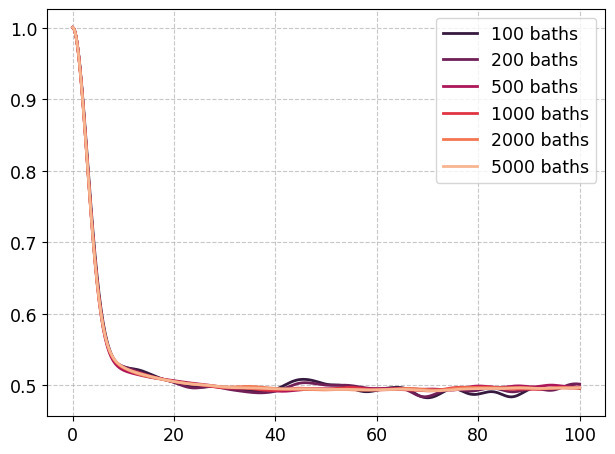

In [7]:
# converge the number of bath configurations 
num_spins = 7

fig, ax = plt.subplots()
colors = sns.color_palette('rocket', n_colors=6)
t_end, t_steps = 100e-6, 500
t_list = np.linspace(0, t_end, t_steps)

for i, num_baths in enumerate([100, 200, 500, 1000, 2000, 5000]):
    batch_idx_list = random.sample(range(1, 51), num_baths//100)
    
    states_merged = 0
    for batch_idx in batch_idx_list: 
        save_filename = f'{num_spins}_spins_batch_{batch_idx}.npy'
        save_loc = os.path.join(save_directory, save_filename)
        states = np.load(save_loc)
        states_merged += states/len(batch_idx_list)

    pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged]
    ax.plot(t_list * 1e6, pop0, color=colors[i], label=f"{num_baths} baths")
ax.legend()
plt.show()

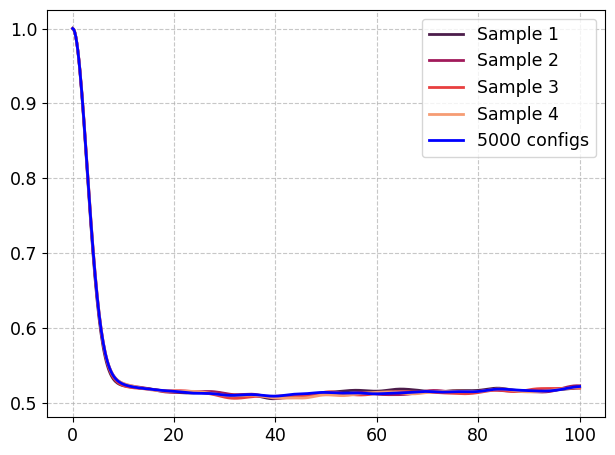

In [11]:
# sampling with the same number of configurations
num_spins = 5
num_configurations = 2000

fig, ax = plt.subplots()
colors = sns.color_palette('rocket', n_colors=4)
t_end, t_steps = 100e-6, 500
t_list = np.linspace(0, t_end, t_steps)

for i in range(4):
    random.seed(i)
    batch_idx_list = random.sample(range(1, 51), num_configurations//100)
    
    states_merged = 0
    for batch_idx in batch_idx_list: 
        save_filename = f'{num_spins}_spins_batch_{batch_idx}.npy'
        save_loc = os.path.join(save_directory, save_filename)
        states = np.load(save_loc)
        states_merged += states/len(batch_idx_list)

    pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged]
    ax.plot(t_list * 1e6, pop0, color=colors[i], label=f"Sample {i+1}")

save_filename = f'{num_spins}_spins_merged.npy'
save_loc = os.path.join(save_directory, save_filename)
states_merged = np.load(save_loc)

pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged]
ax.plot(t_list * 1e6, pop0, color='b', label=f"5000 configs")
    
ax.legend()
plt.show()

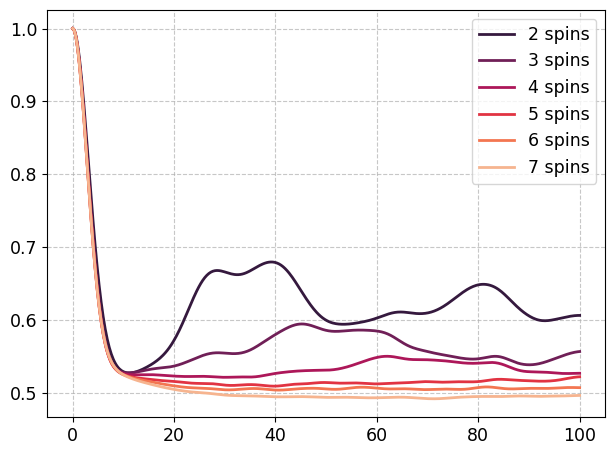

In [8]:
# converge the cutoff radius
colors = sns.color_palette('rocket', n_colors=6)

fig, ax = plt.subplots()
t_end, t_steps = 100e-6, 500
t_list = np.linspace(0, t_end, t_steps)

for i, num_spins in enumerate([2, 3, 4, 5, 6, 7]):
    save_filename = f'{num_spins}_spins_merged.npy'
    save_loc = os.path.join(save_directory, save_filename)
    states_merged = np.load(save_loc)
    
    pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged]
    ax.plot(t_list * 1e6, pop0, color=colors[i], label=f"{num_spins} spins")
ax.legend()
plt.show()

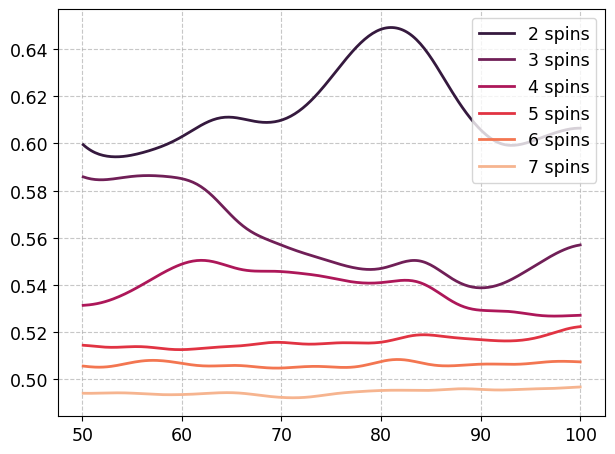

In [7]:
# converge the cutoff radius
colors = sns.color_palette('rocket', n_colors=6)

fig, ax = plt.subplots()
t_end, t_steps = 100e-6, 500
t_list = np.linspace(0, t_end, t_steps)

for i, num_spins in enumerate([2, 3, 4, 5, 6, 7]):
    save_filename = f'{num_spins}_spins_merged.npy'
    save_loc = os.path.join(save_directory, save_filename)
    states_merged = np.load(save_loc)
    
    pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged]
    ax.plot(t_list[250:] * 1e6, pop0[250:], color=colors[i], label=f"{num_spins} spins")
ax.legend()
plt.show()

### 5. Benchmark the converged parameters

In [11]:
save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", "high_density_10nm_depth")

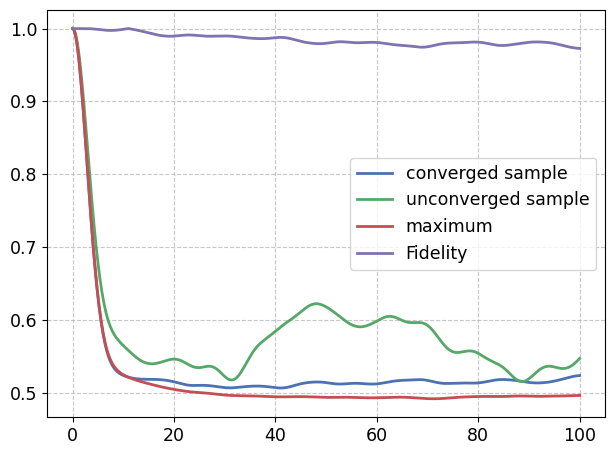

In [12]:
# compare the converged parameters to the maximally calculatable and one unconverged set of parameters
# fidelity cant be defined in the usual way since the states are not pure. difference of population can be considered as trace distance.

colors = sns.color_palette('rocket', n_colors=3)

fig, ax = plt.subplots()
random.seed(123)
t_end, t_steps = 100e-6, 500
t_list = np.linspace(0, t_end, t_steps)

# converge
num_spins = 5
num_configurations = 2000
batch_idx_list = random.sample(range(1, 51), num_configurations//100)

states_merged1 = 0
for batch_idx in batch_idx_list: 
    save_filename = f'{num_spins}_spins_batch_{batch_idx}.npy'
    save_loc = os.path.join(save_directory, save_filename)
    states = np.load(save_loc)
    states_merged1 += states/len(batch_idx_list)

pop0_conv = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged1]
ax.plot(t_list * 1e6, pop0_conv, label='converged sample')

# unconverged
num_spins = 3
num_configurations = 100
batch_idx_list = random.sample(range(1, 51), num_configurations//100)

states_merged2 = 0
for batch_idx in batch_idx_list: 
    save_filename = f'{num_spins}_spins_batch_{batch_idx}.npy'
    save_loc = os.path.join(save_directory, save_filename)
    states = np.load(save_loc)
    states_merged2 += states/len(batch_idx_list)

pop0_unconv = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged2]
ax.plot(t_list * 1e6, pop0_unconv, label='unconverged sample')

# maximum
num_spins = 7 
save_filename = f'{num_spins}_spins_merged.npy'
save_loc = os.path.join(save_directory, save_filename)
states_merged3 = np.load(save_loc)

pop0_max = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states_merged3]
ax.plot(t_list * 1e6, pop0_max, label=f"maximum")

# fidelity
ax.plot(t_list * 1e6, 1-np.abs(np.array(pop0_max) - np.array(pop0_conv)), label='Fidelity' )

ax.legend()
plt.show()

### 6. Benchmark the converged parameters in a magnetic field 

In [95]:
t0 = time.time()

for density_key in ['low_density', 'intermediate_density', 'high_density']:
    for depth in [5e-9, 10e-9, 15e-9]:

        for env_approx_level in ['no_bath', 'full_bath']:
            Bz = 100e-9
            num_configs, num_spins = 2000, 5
            
            directory = os.path.join(os.getcwd(), "baths", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
            
            filename = f'{num_spins}_spins'
            bath_configs = load_spin_baths(filename, directory)
            
            # create an instance of the Environment2 class
            register_config = [('NV', (0, 0, 0), 0, dict(D_gs=0, Bz=Bz, N_zz=0, can_flip=False))]
            bath_configs_batch = bath_configs[:num_configs]
            kwargs = dict(dm_offset=1e-5, verbose=False, env_approx_level=env_approx_level, bath_configs=bath_configs_batch, suter_method=False, thermal_bath=True, parallelization=True)
            env = Environment2(register_config, **kwargs)
            
            # calculate the populations
            t_end, t_steps = 100e-6, 500
            env.gate_props_list = [("free_evo", dict(t=t_end))]
            t_list = np.linspace(0, t_end, t_steps)
            HGate = 1j * env.calc_U_rot(np.pi, 0, theta=np.pi / 4)
            HGate_phase = 1j * env.calc_U_rot(np.pi, np.pi/2, theta=np.pi / 4) # np.pi/2
            old_register_states = [HGate * q.fock_dm(2,0) * HGate]
            states = env.calc_states(t_list=t_list, old_register_states=old_register_states)[0]
            states = np.array([(HGate_phase * state * HGate_phase).full() for state in states])
            
            # saving
            save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
            save_filename = f'.converged_{env_approx_level}_{round(Bz*1e9)}nT_{num_spins}_spins_{num_configs}_conf.npy'
            os.makedirs(save_directory, exist_ok=True)
            save_loc = os.path.join(save_directory, save_filename)
            np.save(save_loc, states)
            print(f'Saved as {save_loc}.npy')
            print("Time: ", time.time()-t0)

Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  0.22169065475463867


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:33<00:00,  3.16it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_5nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  638.2228016853333
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  638.2966983318329


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:58<00:00,  3.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_10nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  1239.3400058746338
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  1239.4024031162262


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:28<00:00,  3.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\low_density_15nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  1870.8071994781494
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  1870.8894221782684


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:52<00:00,  3.38it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_5nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  2465.3616030216217
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  2465.443169116974


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [10:30<00:00,  3.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_10nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  3098.31986784935
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  3098.387687444687


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:59<00:00,  3.71it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\intermediate_density_15nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  3640.170097589493
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  3640.2373657226562


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:46<00:00,  3.80it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_5nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  4169.254194736481
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  4169.338775634766


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:49<00:00,  3.78it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  4700.898597955704
Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\.converged_no_bath_100nT_5_spins_2000_conf.npy.npy
Time:  4700.9691371917725


Sampling over spin baths...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:13<00:00,  3.61it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_15nm_depth\.converged_full_bath_100nT_5_spins_2000_conf.npy.npy
Time:  5256.6784081459045


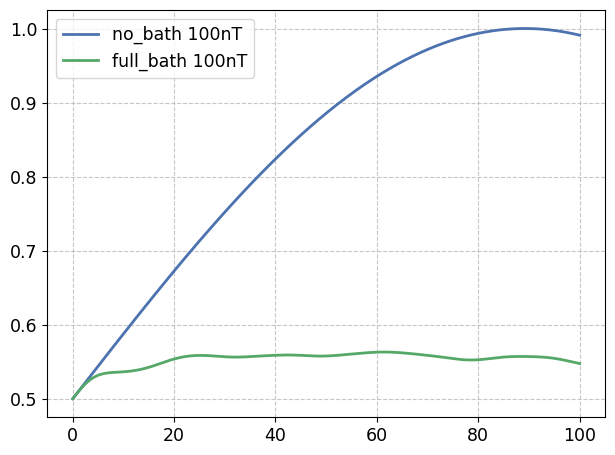

In [111]:
fig, ax = plt.subplots()

density_key = 'intermediate_density'
depth = 10
num_spins = 5

for env_approx_level in ['no_bath', 'full_bath']:
    save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{depth}nm_depth")
    save_filename = f'.converged_{env_approx_level}_{round(Bz*1e9)}nT_{num_spins}_spins_{num_configs}_conf.npy'
    save_loc = os.path.join(save_directory, save_filename)
    states = np.load(save_loc)
    
    pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states]
    ax.plot(t_list * 1e6, pop0, label=f"{env_approx_level} 100nT")

ax.legend()
plt.show()

## Cluster Expansion

In [4]:
density_key = 'high_density'
depth = 10e-9
num_spins = 7

directory = os.path.join(os.getcwd(), "baths", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
filename = f'{num_spins}_spins'
bath_configs, metadata = load_spin_baths(filename, directory, load_metadata=True)

bath_configs_gCCE = []
num_init_states = 200
num_baths = 100

for i in range(num_init_states):
    for bath_config in bath_configs[:num_baths]:
        spin_types, spin_pos, init_states, kwargs_list = list(zip(*bath_config))
        np.random.seed(i) 
        init_states = np.random.choice([0, 1], size=num_spins).tolist()
        config = list(zip(spin_types, spin_pos, init_states, kwargs_list)) 
        bath_configs_gCCE.append(config)

metadata['num_init_states'] = num_init_states
metadata['num_baths'] = num_baths

save_filename = f'{num_spins}_spins_gCCE'
save_spin_baths(bath_configs_gCCE, metadata, directory, save_filename)

In [ ]:
t0 = time.time()

Bz = 0
density_key = 'high_density'
depth = 10e-9
num_spins = 7

directory = os.path.join(os.getcwd(), "baths", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
filename = f'{num_spins}_spins_gCCE'
bath_configs = load_spin_baths(filename, directory)

for env_approx_level in ['gCCE0', 'gCCE1', 'gCCE2']:
    for batch_idx in np.arange(1, 101):
            
            # create an instance of the Environment2 class
            register_config = [('NV', (0, 0, 0), 0, dict(D_gs=0, Bz=Bz, N_zz=0, can_flip=False))]
            bath_configs_batch = bath_configs[(batch_idx-1)*100:batch_idx*100]
            kwargs = dict(dm_offset=1e-5, verbose=False, env_approx_level=env_approx_level, bath_configs=bath_configs_batch, suter_method=False, thermal_bath=True, parallelization=True)
            env = Environment2(register_config, **kwargs)
        
            # calculate the populations
            t_end, t_steps = 100e-6, 500
            env.gate_props_list = [("free_evo", dict(t=t_end))]
            t_list = np.linspace(0, t_end, t_steps)
            HGate = 1j * env.calc_U_rot(np.pi, 0, theta=np.pi / 4)
            HGate_phase = 1j * env.calc_U_rot(np.pi, 0, theta=np.pi / 4) # np.pi/2
            old_register_states = [HGate * q.fock_dm(2,0) * HGate]
            states = env.calc_states(t_list=t_list, old_register_states=old_register_states)[0]
            states = np.array([(HGate_phase * state * HGate_phase).full() for state in states])
            
            # saving
            save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth_gCCE")
            save_filename = f'{num_spins}_spins_{env_approx_level}_batch_{batch_idx}'
            os.makedirs(save_directory, exist_ok=True)
            save_loc = os.path.join(save_directory, save_filename)
            np.save(save_loc, states)
            print(f'Saved as {save_loc}.npy')
            print("Time: ", time.time()-t0)

# time to calculate one batch (100 confs) with 100 init_states
# 474 gCCE0 
# 815 gCCE1
# 1898 gCCE2 * 2000

Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.20it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_1.npy
Time:  4.710561513900757


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.59it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_2.npy
Time:  9.509718894958496


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_3.npy
Time:  14.41910433769226


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_4.npy
Time:  19.328749179840088


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_5.npy
Time:  24.236212730407715


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.56it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_6.npy
Time:  29.112202882766724


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.49it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_7.npy
Time:  33.968027114868164


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.53it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_8.npy
Time:  38.838000774383545


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.30it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_9.npy
Time:  43.5986328125


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.40it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_10.npy
Time:  48.517664670944214


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.50it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_11.npy
Time:  53.376543045043945


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.66it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_12.npy
Time:  58.24542474746704


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.17it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_13.npy
Time:  63.18292951583862


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.18it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_14.npy
Time:  68.11861681938171


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.32it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_15.npy
Time:  72.88876867294312


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.82it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_16.npy
Time:  77.71470713615417


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.36it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_17.npy
Time:  82.61497759819031


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.42it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_18.npy
Time:  87.48802638053894


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.54it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_19.npy
Time:  92.31866693496704


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.33it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_20.npy
Time:  97.07828712463379


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.48it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_21.npy
Time:  101.9704794883728


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_22.npy
Time:  106.81311678886414


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_23.npy
Time:  111.72057175636292


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.69it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_24.npy
Time:  116.56935620307922


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.51it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_25.npy
Time:  121.42878603935242


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.07it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_26.npy
Time:  126.43784379959106


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.39it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_27.npy
Time:  131.19608736038208


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.55it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_28.npy
Time:  136.08381295204163


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.29it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_29.npy
Time:  141.01237869262695


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.34it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_30.npy
Time:  145.89107036590576


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.47it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_31.npy
Time:  150.78521513938904


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_32.npy
Time:  155.54787945747375


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.77it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_33.npy
Time:  160.4179229736328


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_34.npy
Time:  165.28503012657166


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.09it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_35.npy
Time:  170.2381558418274


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.65it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_36.npy
Time:  175.07537007331848


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.31it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_37.npy
Time:  180.00675773620605


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.43it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_38.npy
Time:  185.35271501541138


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.81it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_39.npy
Time:  190.20092797279358


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.01it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_40.npy
Time:  195.26126146316528


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.11it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_41.npy
Time:  200.31515407562256


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.95it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_42.npy
Time:  205.4284210205078


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.98it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_43.npy
Time:  210.40278816223145


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 20.60it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_44.npy
Time:  215.7382333278656


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.00it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_45.npy
Time:  220.74749541282654


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.25it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_46.npy
Time:  225.52844047546387


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.27it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_47.npy
Time:  230.47432589530945


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.22it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_48.npy
Time:  235.5555911064148


Sampling over spin baths...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.62it/s]


Saved as C:\Users\Dennis Herb\OneDrive\2_Uni\Doktor\python_projects\NVcenter\export\.important\converge\high_density_10nm_depth_gCCE\7_spins_gCCE0_batch_49.npy
Time:  240.44755053520203


Sampling over spin baths...:   0%|                                                                                                                                                                                   | 0/100 [00:00<?, ?it/s]

In [186]:
save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth_gCCE")

for env_approx_level in ['gCCE0', 'gCCE1', 'gCCE2']:
    states_merged = 0
    for batch_idx in np.arange(1, 201):
        save_filename = f'{num_spins}_spins_{env_approx_level}_batch_{batch_idx}.npy'
        save_loc = os.path.join(save_directory, save_filename)
        states = np.load(save_loc)
        states_merged += states/200
    save_filename = f'{num_spins}_spins_{env_approx_level}_merged'
    save_loc = os.path.join(save_directory, save_filename)
    np.save(save_loc, states_merged)

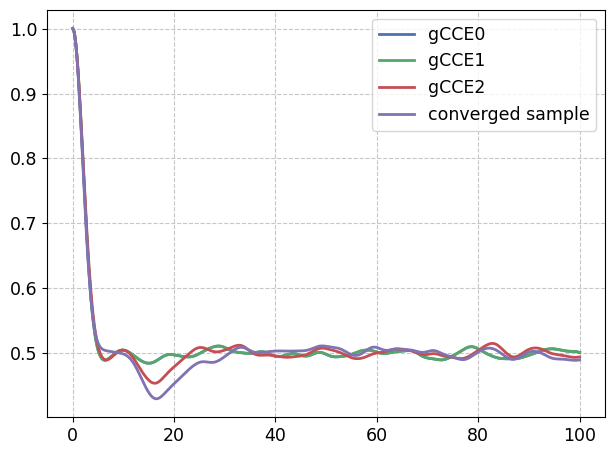

In [14]:
fig, ax = plt.subplots()

density_key = 'very_high_density'
depth = 10e-9
num_spins = 7

for env_approx_level in ['gCCE0', 'gCCE1', 'gCCE2']:
    save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth_gCCE")
    save_filename = f'{num_spins}_spins_{env_approx_level}_merged.npy'
    save_loc = os.path.join(save_directory, save_filename)
    states = np.load(save_loc)
    
    pop0 = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states]
    ax.plot(t_list * 1e6, pop0, label=f"{env_approx_level}")


batch_idx = 1
save_directory = os.path.join(os.getcwd(), "export", ".important", "converge", f"{density_key}_{round(depth*1e9)}nm_depth")
save_filename = f'{num_spins}_spins_batch_{batch_idx}.npy'
save_loc = os.path.join(save_directory, save_filename)
states = np.load(save_loc)

pop0_conv = [q.expect(q.Qobj(state), q.fock_dm(2, 0)).real for state in states]
ax.plot(t_list * 1e6, pop0_conv, label='converged sample')

ax.legend()
plt.show()